In [1]:
import gym
import gym.wrappers
import tianshou as ts
import torch
import numpy as np
import platoonenv
from typing import Union
from pprint import pprint

In [2]:
# envName = "CartPole-v0"
# envName = "MountainCar-v0"
# envName = "Acrobot-v1"
envName = "Platoon-v0"
params=platoonenv.PlatoonEnvParams(
    num_vehicles=10,
    num_vulns=4,
    num_attack=1,
    attack_interval=600
)
def make_env(render_mode: Union[str, None] = None):
    if envName == "Platoon-v0":
        env = gym.make(envName, render_mode=render_mode, params=params)
        # env = gym.wrappers.TimeLimit(env, max_episode_steps=100)
        env = gym.wrappers.TimeLimit(env, max_episode_steps=10)
    else:
        env = gym.make(envName, render_mode=render_mode)
    return env
env = make_env(render_mode="human")

In [3]:
obs_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
print(obs_shape)
print(action_shape)

(10,)
11


In [4]:
from itertools import count
from time import sleep
for i in range(5):
    env.reset()
    reward = 0
    for j in count():
        env.render()
        # sleep(1)
        obs, rew, done, trunc, info = env.step(env.action_space.sample())
        reward += rew
        if trunc or done:
            env.reset()
            print(f"done after {j} steps with {reward} reward")
            break
print(i, "episodes done")

done after 9 steps with -73 reward
done after 9 steps with -75 reward
done after 9 steps with -76 reward
done after 9 steps with -66 reward
done after 9 steps with -78 reward
4 episodes done


In [5]:
env.reset()
for i in range(env.action_space.n):
    print(env.step(i)[0])
    
env.render()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(array([923., 907., 959., 941., 873., 902., 847., 895., 901., 887., 965.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

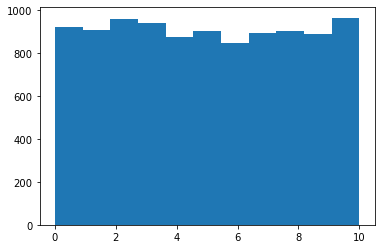

In [6]:
import matplotlib.pyplot as plt
plt.hist([env.action_space.sample() for _ in range(10000)], bins=env.action_space.n)

In [7]:
train_envs = ts.env.DummyVectorEnv([lambda: make_env() for _ in range(10)])
test_envs = ts.env.DummyVectorEnv([lambda: make_env() for _ in range(100)])

In [8]:
seed=12
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)
pass

In [9]:
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor, Critic
hidden_sizes=(128,128,128,128)
net = Net(obs_shape, hidden_sizes=hidden_sizes)
actor = Actor(net, action_shape, softmax_output=True)
actor_optim = torch.optim.Adam(actor.parameters(), lr=1e-4)
net_c1 = Net(obs_shape, hidden_sizes=hidden_sizes)
critic1 = Critic(net_c1, last_size=action_shape)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=1e-3)
net_c2 = Net(obs_shape, hidden_sizes=hidden_sizes)
critic2 = Critic(net_c2, last_size=action_shape)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=1e-3)

In [10]:
# policy = ts.policy.DQNPolicy(net, optim, discount_factor=0.9, estimation_step=3, target_update_freq=320)
alpha = 0.05
alpha_lr = 3e-4
auto_alpha = True
if auto_alpha:
    target_entropy = 0.98 * np.log(np.prod(action_shape))
    log_alpha = torch.zeros(1, requires_grad=True)
    alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
    alpha = (target_entropy, log_alpha, alpha_optim)

In [11]:
from tianshou.exploration import OUNoise
policy = ts.policy.DiscreteSACPolicy(
    actor, actor_optim,
    critic1, critic1_optim,
    critic2, critic2_optim,
    0.005, # tau
    0.95, # gamma
    alpha,
    estimation_step = 3,
    reward_normalization = False,
    # exploration_noise=OUNoise(0.0, 1.2),
)

In [12]:
from tianshou.data import VectorReplayBuffer
train_collector = ts.data.Collector(policy, train_envs, VectorReplayBuffer(20000, 10), exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)

In [13]:
# train_collector.collect(n_step=5000, random=True)

In [14]:
threshold = env.spec.reward_threshold or sum(range(params.num_vehicles))
print("Threshold:", threshold)

Threshold: 45


In [15]:
from tianshou.utils import TensorboardLogger
from torch.utils.tensorboard import SummaryWriter
import os
log_path = os.path.join("log", envName, 'tianplatoon.ipynb')
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [17]:
result = ts.trainer.offpolicy_trainer(
    policy,
    train_collector,
    test_collector,
    max_epoch=100,
    step_per_epoch=10000,
    step_per_collect=10,
    # update_per_step=1,
    update_per_step=0.1,
    episode_per_test=100,
    batch_size=64,
    stop_fn=lambda mean_rewards: mean_rewards >= threshold,
    logger=logger
)
print(f"Finished training! Use {result['duration']}")

Epoch #1:  49%|####8     | 4880/10000 [01:01<01:04, 79.86it/s, alpha=1.380, env_step=4870, len=10, loss/actor=86.219, loss/alpha=-0.003, loss/critic1=29.322, loss/critic2=29.411, n/ep=0, n/st=10, rew=-69.50] 


KeyboardInterrupt: 

In [ ]:
result

{'duration': '15.90s',
 'train_time/model': '13.68s',
 'test_step': 20734,
 'test_episode': 200,
 'test_time': '0.76s',
 'test_speed': '27341.87 step/s',
 'best_reward': 197.99,
 'best_result': '197.99 ± 5.92',
 'train_step': 9730,
 'train_episode': 293,
 'train_time/collector': '1.47s',
 'train_speed': '642.51 step/s'}

In [18]:
policy.eval()
# policy.set_eps(0.05)
collector = ts.data.Collector(policy, ts.env.DummyVectorEnv([lambda: make_env("human")]), exploration_noise=False)
collector.collect(n_episode=10, render=1 / 60)

{'n/ep': 10,
 'n/st': 100,
 'rews': array([-57., -57., -57., -57., -57., -57., -57., -57., -57., -57.]),
 'lens': array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
 'idxs': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'rew': -57.0,
 'len': 10.0,
 'rew_std': 0.0,
 'len_std': 0.0}